In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
pd.set_option('display.max_columns', 500)

In [2]:
# Importing data
df = pd.read_csv('fraud_order_classifier.csv')
df.head()

,order_id,product_id,quantity,selling_price,order_date,shipping_type,user_id,user_account_created_date,address_id,city,pincode,phone,vertical,discount,count_14_days,count_28_days,count_56_days,category_purchase_count_bks,category_purchase_count_X4kt,category_purchase_count_X4rr,category_purchase_count_dep,category_purchase_count_kyh,category_purchase_count_mgl,category_purchase_count_dgv,category_purchase_count_ixq,category_purchase_count_X26x,category_purchase_count_t06,category_purchase_count_amz,category_purchase_count_reh,category_purchase_count_ckf,category_purchase_count_j9e,category_purchase_count_jek,category_purchase_count_tyy,category_purchase_count_vdm,category_purchase_count_X6bo,category_purchase_count_X2oq,category_purchase_count_mcr,category_purchase_count_osp,category_purchase_count_r18,label
0,a2183866942a8ecd252727d95130ff29,e7b06ca068c7f50b06ecb5758b51258d,1,5507,2014-05-24,non-ndd,00305fba264d3fd74b9da8cb8c6ab654,2012-08-13 06:04:03,9701f7016eff920d184e4764aac211e2,9f6774de2352cf01e1be77f8aa4cf604,0072c03dc788f3914635ccc956b6fe4b,00001a7f0efb99508907be3eba5cc8ab,Handset,18.942,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
1,61c2c93a011a78c76d2e720120bbfd4c,7fec8d8425a12add61c7a83d8270a0cb,1,6999,2014-05-23,ndd,f1f9a2662d06cfd0abc8d2b7147ade37,2012-04-25 09:08:45,a3c2e034510ab9f992bf86ad6327fc6b,89e5701b3aee3a4011e76c441044028b,b4ec1f705e664ba907ce1ce14125cc2f,000027799e494160ebada3a8887dd37a,Handset,1.946,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
2,4049bffb21037c1ba41064802baa86f6,59f6d6f76798b14e053f136a5c726d65,1,5589,2014-05-28,non-ndd,a3e8c45cd263e72f7001303a8b22649c,2012-08-10 18:44:49,8fc0ad66f61f9612d9aec2e0ddeebc10,64f692fc1ed662e37a49acaf1c0d0b4a,64aab4822a93ee289b127feffe5ec856,000046d64a9eaaf8832f717e3cfa5c72,MobileTabletWithCallFacility,28.819,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
3,51317d4d2583de8a4813972c94637449,a57566363f05f7bba50c1f7d3d6a93f8,1,79,2014-05-27,non-ndd,beda308ae5e3bfcefd1d9394c6532bce,2012-10-19 00:56:02,ee8df0f2fb20e881eb503748fa653d29,90a60ca1704e4b34248b98bc417c4f58,4affb666770e43a21a8c3f3b9e1cf5dc,00005ebc921ffb6b3f0f3ba772feb585,Book,25.760,2,2,2,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,26.0,0.0,2.0,1.0,0.0,1.0,16.0,0.0,3.0,7.0,0.0,1.0,2.0,normal
4,25bc2ec67785edcfa5f93ee14023bf8b,3a54c84b0446bf27d46df55edb48c2e1,1,147,2014-05-27,non-ndd,beda308ae5e3bfcefd1d9394c6532bce,2012-10-19 00:56:02,ee8df0f2fb20e881eb503748fa653d29,90a60ca1704e4b34248b98bc417c4f58,4affb666770e43a21a8c3f3b9e1cf5dc,00005ebc921ffb6b3f0f3ba772feb585,Book,35.119,1,1,1,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,26.0,0.0,2.0,1.0,0.0,1.0,16.0,0.0,3.0,7.0,0.0,1.0,2.0,normal


In [3]:
# Vertical x Label
fraud_percentage = df.groupby('vertical').agg({
    'label': [
        ('total', 'count'),
        ('fraud_count', lambda x: (x == 'fraud').sum())
    ]
}).reset_index(drop=False)
fraud_percentage.columns = ['vertical', 'total', 'fraud_count']
fraud_percentage['vertical_fraud_rate'] = (fraud_percentage['fraud_count'] / fraud_percentage['total']) * 100
df = pd.merge(df, fraud_percentage, on=['vertical'],
        how='left')

### Split training and testing data

In [4]:
# Encoding target variable with rare class 'fraud' as 1 and 'normal' class as 0
label_map = {
    'fraud':1,
    'normal':0}
target = df['label'].map(label_map)

# Splitting the data into train and test split of 20%
# Performed stratified sampling such that both classes are represented well in training and test data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['label'], axis=1), 
                                                    target, 
                                                    random_state=42, 
                                                    stratify=target, 
                                                    test_size=0.2)

### Training data creation

Thought process
- Not considering order_month as it is constant across time period

In [5]:
# Time related features
def time_level_features(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['user_account_created_date'] = pd.to_datetime(df['user_account_created_date'])
    df['account_age_month'] = (df['order_date'] - df['user_account_created_date']).dt.days / 30

    df['order_day_of_week'] = df['order_date'].dt.dayofweek
    df['is_weekend'] = df['order_day_of_week'].isin([5, 6]).astype(int)
    return df

def sales_features(df):
    df['price'] = df['selling_price'] / df['quantity']
    # from EDA, we know that mean discount for normal cases : ~15%
    # mean discount for fraud cases : ~17%
    df['discount_flag'] = df['discount'].apply(lambda x: 1 if x > 16 else 0)
    return df

# User related features
def user_features(df):
    # Order frequency changes
    df['order_frequency_ratio_14_28'] = df['count_14_days'] / df['count_28_days']
    df['order_frequency_ratio_28_56'] = df['count_28_days'] / df['count_56_days']
    return df

# Product related features
def product_features(df):
    # Creating the features at vertical level -> price, discount, quantity
    df_temp = df.groupby(['vertical']).agg({
        'price':'mean',
        'discount':'mean',
        'quantity':'mean'
        }).reset_index(drop=False)
    df_temp.columns = ['vertical', 'vertical_price', 'vertical_discount', 'vertical_quantity']
    return pd.merge(df, df_temp, on=['vertical'], how='left')

# Address related features
def address_features(df):
    # As per EDA, Number of unique cities and phones across users
    # follows highly skewed right tail distribution
    user_data = df.groupby('user_id').agg({
        'city':'nunique',
        'phone':'nunique'
    }).reset_index(drop=False)
    user_data.columns = ['user_id', 'city_flag', 'phone_flag']

    user_flags = ['city_flag', 'phone_flag']
    user_data[user_flags] = user_data[user_flags].map(lambda x: 1 if x > 5 else 0)
    df = pd.merge(df, user_data, on=['user_id'],
                     how='left')
    return df

def product_features_test(train_df, test_df):
    # Getting mean price, discount, quantity from training data for test data
    # Imputing new verticals in test data using mean of train data
    cols = ['vertical', 'vertical_price', 'vertical_discount', 'vertical_quantity']
    temp_df = train_df[cols].drop_duplicates()
    test_df = pd.merge(test_df, temp_df, 
                       on=['vertical'],
                       how='left')
    # For new verticals in test data -> impute using mean
    numeric_columns = [col for col in temp_df.columns if col.startswith('vertical_')]
    test_df[numeric_columns].fillna(temp_df[numeric_columns].mean())
    return test_df

def address_features_test(train_df, test_df):
    # Getting city, phone flags at user level from training data for test data
    # Imputing city, phone in new users in test data as 0 (normal)
    cols = ['user_id', 'city_flag', 'phone_flag']
    temp_df = train_df[cols].drop_duplicates()
    test_df =  pd.merge(test_df, temp_df, 
             on=['user_id'],
             how='left') 
    # For new verticals in test data -> keep it non-flag
    test_df[cols].fillna(0)
    return test_df

In [6]:
# Feature Engineering
X_train = time_level_features(X_train)
X_train = sales_features(X_train)
X_train = user_features(X_train)
X_train = product_features(X_train)
X_train = address_features(X_train)

In [7]:
# Feature Transformation - Training

# Mapping premium shipping as 1 and non-premium as 0
shipping_map = {
        'ndd':1,
        'non-ndd':0}
X_train['shipping'] = X_train['shipping_type'].map(shipping_map)

# Standardisation led to better model evaluation metrics
# Missing Value Imputation : NA values have been kept as is as we are using Random Forest Classifier
sc = StandardScaler()
category_columns = [col for col in df.columns if col.startswith('category_purchase_count_')]
X_train[category_columns] = sc.fit_transform(X_train[category_columns])

In [8]:
# Feature Transformation - Testing
X_test = time_level_features(X_test)
X_test = sales_features(X_test)
X_test = user_features(X_test)
X_test = product_features_test(X_train, X_test)
X_test = address_features_test(X_train, X_test)
X_test['shipping'] = X_test['shipping_type'].map(shipping_map)
X_test[category_columns] = sc.transform(X_test[category_columns])

### Modelling

In [9]:
features = ['account_age_month', 'order_day_of_week', 'is_weekend', 
            'price', 'discount_flag',
            'vertical_fraud_rate', 'vertical_price', 'vertical_discount', 'vertical_quantity',
            'discount', 'shipping', 'quantity', 'selling_price',
            'city_flag', 'phone_flag',
            'order_frequency_ratio_14_28', 'order_frequency_ratio_28_56',
            'category_purchase_count_bks',
            'category_purchase_count_X4kt', 'category_purchase_count_X4rr',
            'category_purchase_count_dep', 'category_purchase_count_kyh',
            'category_purchase_count_mgl', 'category_purchase_count_dgv',
            'category_purchase_count_ixq', 'category_purchase_count_X26x',
            'category_purchase_count_t06', 'category_purchase_count_amz',
            'category_purchase_count_reh', 'category_purchase_count_ckf',
            'category_purchase_count_j9e', 'category_purchase_count_jek',
            'category_purchase_count_tyy', 'category_purchase_count_vdm',
            'category_purchase_count_X6bo', 'category_purchase_count_X2oq',
            'category_purchase_count_mcr', 'category_purchase_count_osp',
            'category_purchase_count_r18'
           ]

In [10]:
# Modelling using Decision Tree
# clf = DecisionTreeClassifier(random_state=42)

# Modelling using Random Forest
clf = RandomForestClassifier(n_estimators=50,
                             max_depth=24,
                             random_state=42)
clf.fit(X_train[features], y_train)

RandomForestClassifier(max_depth=24, n_estimators=50, random_state=42)

### Evaluation on training data

AUC:  0.992


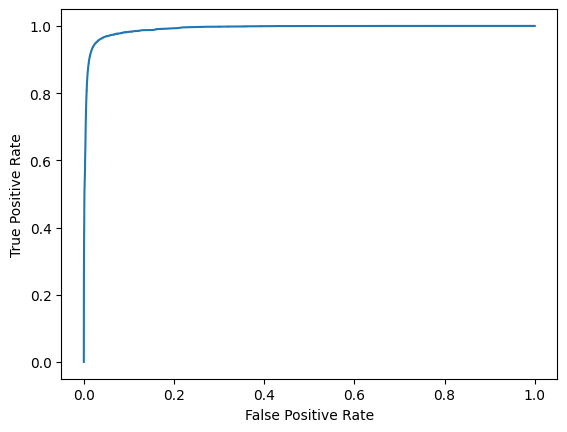

In [11]:
preds = clf.predict_proba(X_train[features])[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, preds)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("AUC: ", round(roc_auc_score(y_train, preds), 3))

In [12]:
import numpy as np
from sklearn.metrics import f1_score

def find_optimal_threshold(y_true, y_pred_proba):
    thresholds = np.arange(0, 1.01, 0.01)
    f1_scores = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    optimal_f1 = max(f1_scores)
    return optimal_threshold, optimal_f1

# Threshold from training data will be used to get predictions on test data
optimal_threshold, optimal_f1 = find_optimal_threshold(y_train, preds)

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Optimal F1-score: {optimal_f1:.4f}")

Optimal threshold: 0.35
Optimal F1-score: 0.8449


In [13]:
y_pred_optimal = (preds >= optimal_threshold).astype(int)
print(classification_report(y_train, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    367221
           1       0.83      0.86      0.84     17664

    accuracy                           0.99    384885
   macro avg       0.91      0.93      0.92    384885
weighted avg       0.99      0.99      0.99    384885



Evaluation metrics on training data
- Precision : 0.83
- Recall : 0.86
- F1-Score : 0.84

### Evaluation on test data

In [14]:
# Apply the optimal threshold to your predictions
preds_test = clf.predict_proba(X_test[features])[:, 1]
y_pred_optimal = (preds_test >= optimal_threshold).astype(int)
print(classification_report(y_test, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     91806
           1       0.71      0.69      0.70      4416

    accuracy                           0.97     96222
   macro avg       0.85      0.84      0.84     96222
weighted avg       0.97      0.97      0.97     96222



Evaluation metrics on test data
- Precision : 0.71
- Recall : 0.69
- F1-Score : 0.70

AUC:  0.965


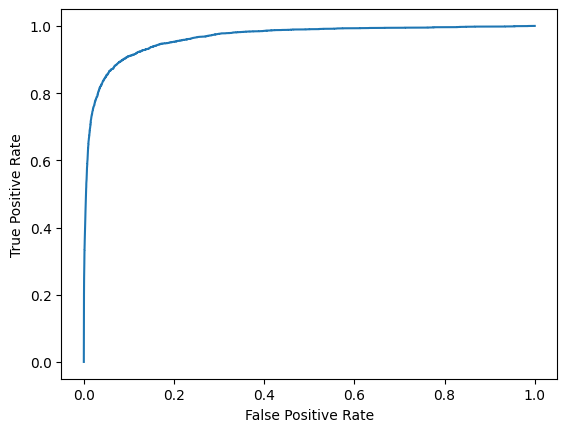

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, preds_test)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("AUC: ", round(roc_auc_score(y_test, preds_test), 3))

#### Result Report

1. Random Forest Classifier, F1 : 0.70
2. Decision Tree Classifier, F1 : 0.65